# Bayes by Backprop
An implementation of the algorithm described in https://arxiv.org/abs/1505.05424.  
This notebook accompanies the article at https://www.nitarshan.com/bayes-by-backprop.

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from copy import deepcopy

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

True


## Data Preparation

In [3]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

# train_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10(
#         '../gitignored/data', train=True, download=True,
#         transform=transforms.ToTensor()),
#     batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
# test_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10(
#         '../gitignored/data', train=False, download=True,
#         transform=transforms.ToTensor()),
#     batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

## Modelling
$$\underline{\text{Reparameterized Gaussian}}$$
$$\begin{aligned}
\theta &= (\mu, \rho)\\
\sigma &= \ln{(1+e^\rho)}\\
\mathcal{N}(x\vert \mu, \sigma) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}\\
\ln{\mathcal{N}(x\vert \mu, \sigma)} &= -\ln{\sqrt{2\pi}} -\ln{\sigma} -\frac{(x-\mu)^2}{2\sigma^2}\\
P(\mathbf{w}) &= \prod_j{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}}\\
\end{aligned}$$

In [4]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
        self.mask = torch.ones_like(self.mu)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + (self.sigma * epsilon) * self.mask.to(self.mu.device)
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

$$\underline{\text{Scale Mixture Gaussian}}$$
$$\begin{align}
P(\mathbf{w}) &= \prod_j{\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{(\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2))}}\\
\end{align}$$

In [5]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

$$\pi = \frac{1}{2}$$
$$-\ln{\sigma_1} = 0$$
$$-\ln{\sigma_2} = 6$$

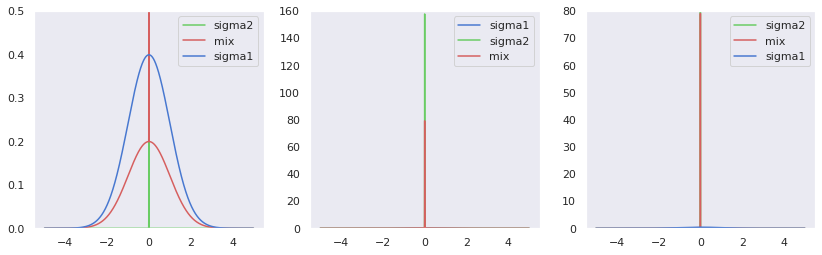

In [6]:
PI = 0.5
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])

def visualize_scale_mixture_components():
    def show_lines():
        pass
    mix = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
    normal_1 = torch.distributions.Normal(0, SIGMA_1)
    normal_2 = torch.distributions.Normal(0, SIGMA_2)
    x_points = np.linspace(-5,5,10000)
    d1 = np.array([torch.exp(normal_1.log_prob(float(c))) for c in x_points])
    d2 = np.array([torch.exp(normal_2.log_prob(float(c))) for c in x_points])
    d3 = np.array([torch.exp(mix.log_prob(float(c))) for c in x_points])
    plt.subplots(1,3,figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,0.5)
    plt.subplot(1,3,2)
    plt.plot(x_points,d1,color="b")
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.legend(["sigma1", "sigma2", "mix"])
    plt.ylim(0,160)
    plt.subplot(1,3,3)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,80)
    
visualize_scale_mixture_components()

In [7]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [8]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 1200)
#         self.l1 = BayesianLinear(3*32*32, 1200)
        self.l2 = BayesianLinear(1200, 1200)
        self.l3 = BayesianLinear(1200, 10)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
#         x = x.view(-1, 3*32*32)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

net = BayesianNetwork().to(DEVICE)

## Training

In [9]:
def write_weight_histograms(epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/w3_mu', net.l3.weight_mu,epoch)
    writer.add_histogram('histogram/w3_rho', net.l3.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)
    writer.add_histogram('histogram/b3_mu', net.l3.bias_mu,epoch)
    writer.add_histogram('histogram/b3_rho', net.l3.bias_rho,epoch)

def write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)

In [10]:
def train(net, optimizer, epoch):
    net.train()
    if epoch == 0: # write initial distributions
        write_weight_histograms(epoch)
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    write_weight_histograms(epoch+1)

In [11]:
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer, epoch)

  0%|          | 0/600 [00:00<?, ?it/s]/nfs/homedirs/ayle/miniconda3/envs/gr/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 600/600 [00:52<00:00, 11.41it/s]


In [35]:
backup_net = deepcopy(net)

In [36]:
net = deepcopy(backup_net)

In [14]:
# for name, module in net.named_modules():
#     if name in ['l1', 'l2']:
#         breakpoint()

In [37]:
all_scores = []
for name, module in net.named_modules():
    if name in ['l1', 'l2']:
#         scores = - module.weight.sigma
        scores = torch.abs(module.weight.mu) / module.weight.sigma
        all_scores.append(scores.flatten())

In [38]:
all_scores = torch.cat([x for x in all_scores])

In [17]:
# all_scores

In [18]:
# torch.histc(all_scores, 10)

In [39]:
threshold, _ = torch.topk(all_scores, int(len(all_scores)*0.25), sorted=True)

In [41]:
acceptable_score = threshold[-1]

In [42]:
acceptable_score

tensor(0.4454, device='cuda:0', grad_fn=<SelectBackward>)

In [43]:
for name, module in net.named_modules():
    if name in ['l1', 'l2']:
        mask = (torch.abs(module.weight.mu) / module.weight.sigma > acceptable_score)
#         mask = (- module.weight.sigma) > acceptable_score
        module.weight.mu = mask * module.weight.mu
        module.weight.mask = mask
        
        print(mask.sum().float() / torch.numel(mask))

tensor(0.2833, device='cuda:0')
tensor(0.2283, device='cuda:0')


## Evaluation

### Model Ensemble

In [23]:
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

Component 0 Accuracy: 8473/10000
Component 1 Accuracy: 8534/10000
Component 2 Accuracy: 8508/10000
Component 3 Accuracy: 8493/10000
Component 4 Accuracy: 8528/10000
Component 5 Accuracy: 8480/10000
Component 6 Accuracy: 8508/10000
Component 7 Accuracy: 8526/10000
Component 8 Accuracy: 8476/10000
Component 9 Accuracy: 8511/10000
Posterior Mean Accuracy: 8658/10000
Ensemble Accuracy: 8750/10000


### Model Uncertainty

#### In-Domain Uncertainty

In [24]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tensor([9, 2, 1, 1, 6])


Traceback (most recent call last):
  File "/nfs/homedirs/ayle/miniconda3/envs/gr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/nfs/homedirs/ayle/miniconda3/envs/gr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/nfs/homedirs/ayle/miniconda3/envs/gr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/nfs/homedirs/ayle/miniconda3/envs/gr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


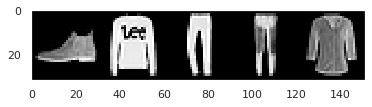

In [25]:
fmnist_sample = iter(test_loader).next()
fmnist_sample[0] = fmnist_sample[0].to(DEVICE)
print(fmnist_sample[1])
sns.set_style("dark")
show(make_grid(fmnist_sample[0].cpu()))

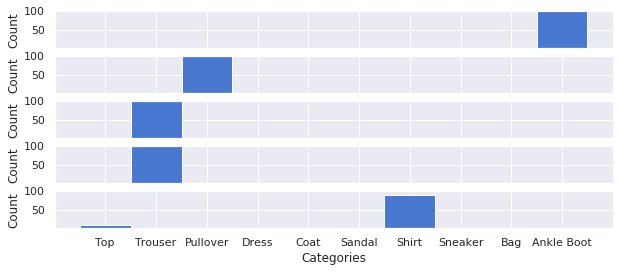

In [26]:
net.eval()
fmnist_outputs = net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    fmnist_outputs = np.append(fmnist_outputs, net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(fmnist_outputs[i], np.arange(-0.5, 10, 1))

#### Out-of-Domain Uncertainty

In [27]:
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../gitignored/data', train=False, download=True, transform=transforms.ToTensor()), batch_size=5, shuffle=False)

# mnist_loader = torch.utils.data.DataLoader(
#     datasets.SVHN('../gitignored/data', split='test', download=True, transform=transforms.ToTensor()), batch_size=5, shuffle=False)

In [28]:
from sklearn import metrics
import numpy as np


def calculate_auroc(correct, predictions):
    fpr, tpr, thresholds = metrics.roc_curve(correct, predictions)
    auroc = metrics.auc(fpr, tpr)
    return auroc


def calculate_aupr(correct, predictions):
    aupr = metrics.average_precision_score(correct, predictions)
    return aupr

In [44]:
ood_labels = []
ood_scores = []

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(DEVICE)
        out = net(data, True)
        probs = F.softmax(out, 1)

        max_probs, _  = probs.max(1)
        max_probs = max_probs.detach().cpu().numpy()
        ood_labels.append(np.ones_like(max_probs))
        ood_scores.append(max_probs)

    for data, _ in mnist_loader:
        data = data.to(DEVICE)
        out = net(data, True)
        probs = F.softmax(out, 1)

        max_probs, _  = probs.max(1)
        max_probs = max_probs.detach().cpu().numpy()
        ood_labels.append(np.zeros_like(max_probs))
        ood_scores.append(max_probs)
    
ood_labels = np.concatenate(ood_labels)
ood_scores = np.concatenate(ood_scores)

In [50]:
ood_scores[10000:].mean()

0.61573786

In [45]:
print(calculate_auroc(ood_labels, ood_scores))
print(calculate_aupr(ood_labels, ood_scores))

0.806807095
0.7904221162692503


In [31]:
# 0.7348483900000001
# 0.7189197489131008

# 0.6768591982944069
# 0.495362640026969

# 0.657779435
# 0.6424149416360756

tensor([7, 2, 1, 0, 4])


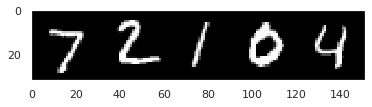

In [32]:
mnist_sample = iter(mnist_loader).next()
mnist_sample[0] = mnist_sample[0].to(DEVICE)
print(mnist_sample[1])
sns.set_style("dark")
show(make_grid(mnist_sample[0].cpu()))

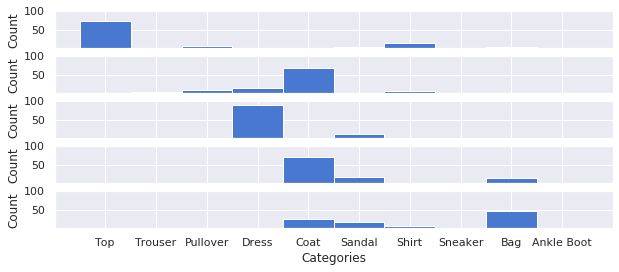

In [46]:
net.eval()
mnist_outputs = net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    mnist_outputs = np.append(mnist_outputs, net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)

sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(mnist_outputs[i], np.arange(-0.5, 10, 1))

In [34]:
%load_ext watermark
%watermark --updated --datename --python --machine --watermark -p torch,numpy,matplotlib,tensorboardX,torchvision,seaborn

ModuleNotFoundError: No module named 'watermark'